# Introduction


In mathematics, a time series is a series of data points arranged in chronological order. Most commonly, a time series is a sequence of time points extracted at consecutive equal intervals. So, it is a discrete-time data series and is also used for non-stationary data, i.e., data that constantly fluctuates over time or is affected by time. Through this method, it can help organizations to understand the underlying causes of trends or systematic patterns over a period of time.

The objective of the project is to perform an exploratory data analysis of the balance dataset for the past five years using python, and then predict the total balance for the next twelve months using ARIMA and SARIMAX models.

In the process, the accuracy of the models will be validated in the hopes of accurately predicting future trends to support the project.

# Read Data

* Create a work folder on GDrive, e.g. 'My Drive/Colab Notebooks/courseproject'.
* Add the shortuct to the data file 'loans_head.csv' on GDrive that was given with the assignment.
* Mount GDrive to Colab Session

In [ ]:
# Mount GDrive
# change dir to the folder where all your project work will be done
#
# pre-requisite:
# have Google Drive account
# create Colab Notebooks folder at the root, i.e. in 'My Drive'
#   this folder will store all your future Colab work
# create a project sub-folder, suppose you named it 'my_project' and replace
#   <YOUR_PATH> in the script with this name
#   then this location becomes your current directory once this script runs
import os
import numpy as np
import pandas as pd
import math

gdrp = '/content/gdrive/'
from google.colab import drive
try:
  drive.mount(gdrp)
except:
  drive.mount(gdrp, force_remount=True)
  print('drive mounted')

rootpath = gdrp + 'My Drive/Colab Notebooks/financial economics'
os.chdir(rootpath)

import pandas as pd

df1 = pd.read_csv('loans_head.csv', parse_dates=True)
first_column = df1.iloc[:, 0]
logdb = np.log(df1.iloc[:, 1:].sum(axis=1))
df = pd.DataFrame({
    'date': first_column,
    'logdb': logdb
})
df2 = pd.read_csv('loans_head.csv', parse_dates=True, index_col=0).asfreq('MS')
sum_of_the_other_columns = df2.iloc[:, 1:].sum(axis=1)
logdb2 = np.log(sum_of_the_other_columns)
df2 = pd.DataFrame({
    'logdb2': logdb2
})

Mounted at /content/gdrive/


# Load data

<Axes: >

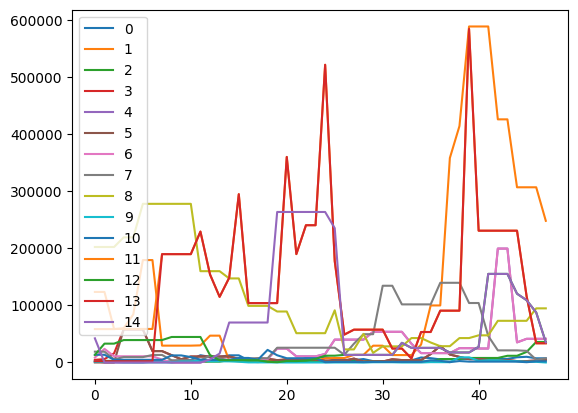

In [ ]:
df1.iloc[:,:16].plot()

# Exploratory Data Analysis



Upon taking the logarithm, the time series data exhibits a flatter trend, suggesting a reduced standard deviation.

<ipython-input-3-a5e9af8a9842>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  log_values = np.log(df1.sum(axis=1))


<Axes: >

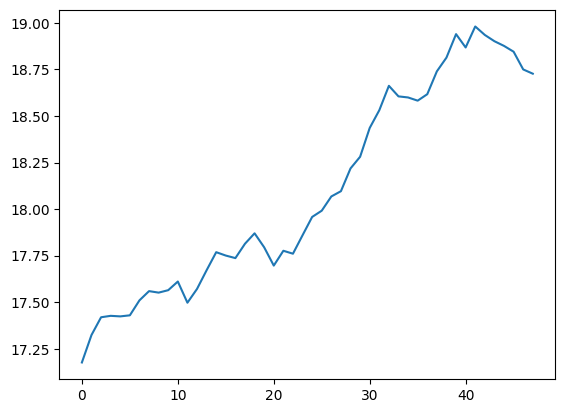

In [ ]:
log_values = np.log(df1.sum(axis=1))
log_values.plot()

ADF tests whether a time series has a unit root by means of a difference operation to determine whether the time series is stationary.

$$\begin{equation}
    \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \cdots + \delta_p \Delta y_{t-p} + \varepsilon_t
\end{equation}$$

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(logdb)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.295894
p-value: 0.631049


The log of total balance is not stationary. With a ADF statistics of -1.295894, we failed rejected the null hypothesis, so there is a unit root.

## Difference Order

An autocorrelation plot of the original series shows the correlation between the time series data and itself at different time lags. The autocorrelation is calculated by the formula:
$$\text{ACF}(k) = \frac{\sum_{t=k+1}^{n}(x_t - \bar{x})(x_{t-k} - \bar{x})}{\sum_{t=1}^{n}(x_t - \bar{x})^2}$$


First-order differencing is a common method used in time series analysis to help eliminate the trend component in a time series and smooth out a non-stationary time series. Its formula is:
$$\Delta x_t = x_t - x_{t-1}$$


The second-order differencing further enhances the effect of the first-order differencing by eliminating the seasonal component in the time series. Its formula is:
$$\Delta^2 x_t = (\Delta x_t) - (\Delta x_{t-1})$$
$$\Delta^2 x_t = x_t - 2x_{t-1} + x_{t-2}$$

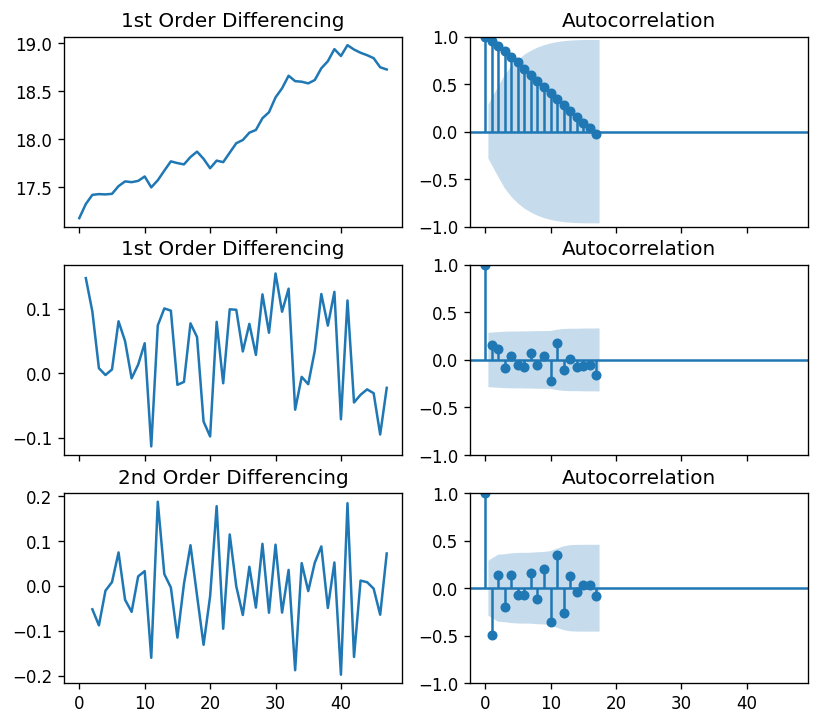

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({'figure.figsize':(8,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(logdb); axes[0, 0].set_title('1st Order Differencing')
plot_acf(logdb.dropna(), ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(logdb.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(logdb.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(logdb.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(logdb.diff().diff().dropna(), ax=axes[2, 1])


plt.show()

The first order differenced data is stationary.

In [ ]:
result_first_diff = adfuller(logdb.diff().dropna()  )
# result_second_diff = adfuller(logdb.diff().diff().dropna())

print('ADF Statistic: %f' % result_first_diff[0])
print('p-value: %f' % result_first_diff[1])
# print('ADF Statistic: %f' % result_second_diff[0])
# print('p-value: %f' % result_second_diff[1])

ADF Statistic: -5.788927
p-value: 0.000000


In general, the more negative the value of the ADF statistic, the stronger the evidence that the sequence rejects the existence of a unit root.

According to the result, ADF statistic = -5.788927, which is a negative value and relatively large in absolute value. Therefore the series is stationary.

Then the p-value approximates 0, which again demonstrates that the series is stationary.

## ACF and PACF

Formula of Differencing:
$$\Delta y_t = y_t - y_{t-1}$$

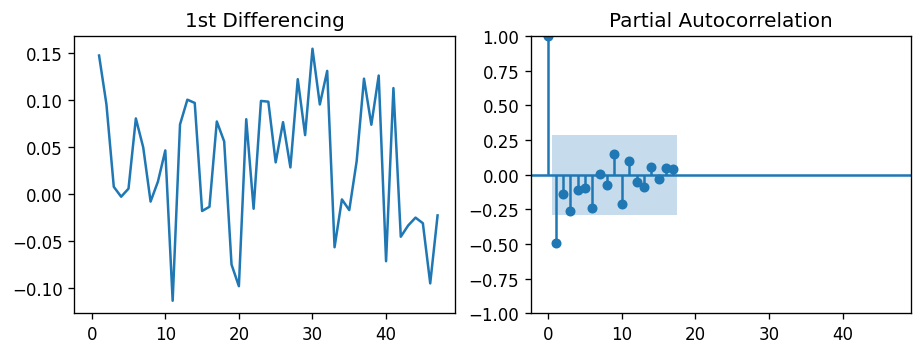

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(logdb.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(logdb.diff().diff().dropna(), ax=axes[1])

plt.show()

According to the right panel we can observe that the biased autocorrelation coefficients are close to zero except for the first delay (lag 1), which may imply that maybe p=1 and the time series stabilizes after a single differencing.

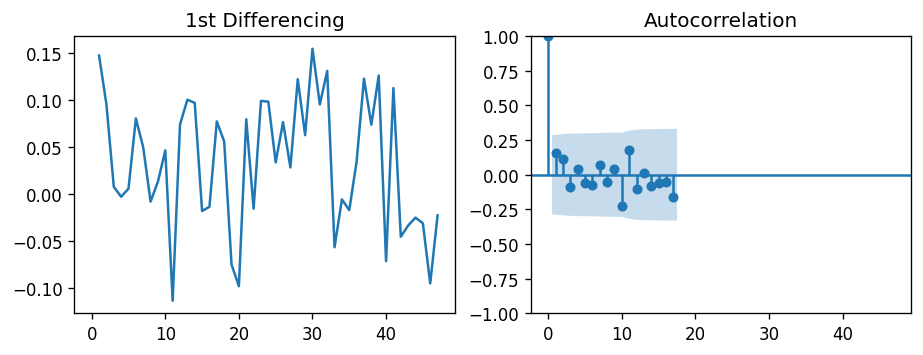

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(logdb.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-1,1))
plot_acf(logdb.diff().dropna(), ax=axes[1])

plt.show()

From this analysis of the first order difference plots, we can see that the series becomes stationary after being differenced, indicating that it is suitable for ARIMA modeling.

Meanwhile, the original dataset is significantly autocorrelated after being differenced because it means that the current values have a strong linear relationship with the past values.

# Model Description

## ARIMA model

AIC(Akaike Information Criterion) is employed as our primary metric for complexity and  interpretability in the ARIMA model. AIC's penalty term only depends on the number of parameters in the model instead of the sample size. It enhances model fit assessment for small samples more, compared with BIC(Bayesian Information Criterion), leading to more accurate forecasting. The AIC is calculated by the formula:



$$\text{AIC} = -2 \ln(\hat{L}) + 2k$$

After comparing the following ARIMA models, we choose the model with lowest AIC (ARIMA(1,1,1)):

$$\Delta \ln x_t= 0.92 \Delta \ln x_{t-1}+w_t-0.74 w_{t-1}$$

$\Delta \ln x_t$ represents the first difference of the natural logarithm of the time series x at time t.

$w_t$ is the error term at time t.

 A 1% increase in the previous total balance results in a 0.91% increase in the current balance. Furthermore, a 1 unit increase in the error term corresponds to a -0.7% increase in the current balance. It is worth noting that the variance of the error term, represented by sigma square, is 0.005, indicating a relatively low level of variability in the error term.


The AIC and BIC table of the ARIMA model is shown as follows:

| Model | AIC | BIC |
|-----|-----|-----|
| ARIMA(1,1,1) | -108.867| -103.317 |
| ARIMA(1,1,0)  | -107.873 | -104.173 |
| ARIMA(0,1,1)  | -106.270 | -102.569|
| ARIMA(0,1,0)  |  -105.200 | -103.350 |




In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(endog=df2, order=(1, 1, 1))

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 logdb2   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  57.426
Date:                Fri, 15 Dec 2023   AIC                           -108.853
Time:                        03:48:54   BIC                           -103.302
Sample:                    07-01-2018   HQIC                          -106.764
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9174      0.111      8.275      0.000       0.700       1.135
ma.L1         -0.7411      0.207     -3.578      0.000      -1.147      -0.335
sigma2         0.0050      0.002      3.362      0.0

## SARIMAX model

AIC is continued to be used as our primary metrics to caompare the complexity and  interpretability in the SARIMAX model as it better concern the goodness of fit of the model.


$$\text{AIC} = -2 \ln(\hat{L}) + 2k$$

In SARIMAX mode, we introduce U.S. 10 year treasury rate from 2018-07-01 to 2022-06-01  as the exogenous variable,because as a key macroeconomic indicator, the 10-year government bond yield is widely regarded as the benchmark interest rate in financial markets, influencing various other rates, including loan and mortgage rates.


The model we chose before adjusting for the model performance (SARIMAX(1,1,1)):

$$\Delta ln x_t = 0.77 \Delta ln x_{t-1} - 0.06 y_t + \varepsilon_t \\
\varepsilon_t = - 0.47 \Delta\varepsilon_{t-1} + n_t $$



where:

$\ln x_t $ is the log of observed time series at time t

$y_t $  is the exogenous variables at time t

$\varepsilon_t$ is the error term at time t

$n_t $ is the white noise error term at time t.

The AIC and BIC table of the SARIMAX model is shown as follows:

| Model | AIC | BIC |
|-----|-----|-----|
| SARIMAX(1,1,1)  |  -106.290 | -98.889|
| SARIMAX(1,1,0)  | -106.064 |  -100.514 |
| SARIMAX(2,1,0)  |  -105.433 | -98.032|
| SARIMAX(2,1,1)  |  -105.235 | -95.984|
| SARIMAX(0,1,1)  |  -104.804 | -99.254|
| SARIMAX(1,1,2)  |  -104.676 | -95.425|
| SARIMAX(0,1,2) | -104.629| -97.229|
| SARIMAX(0,1,0)  |  -104.105| -100.404 |
| SARIMAX(2,1,2)  |  -102.229 | -91.128|

## exogenous variable


observation_date
2022-02-01    18.901505
2022-03-01    18.876290
2022-04-01    18.845134
2022-05-01    18.749932
2022-06-01    18.727084
Freq: MS, Name: logdb2, dtype: float64
DATE
2022-01-01   -0.65
2022-02-01   -0.79
2022-03-01   -0.52
2022-04-01    0.01
2022-05-01    0.21
Freq: MS, Name: DFII10, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


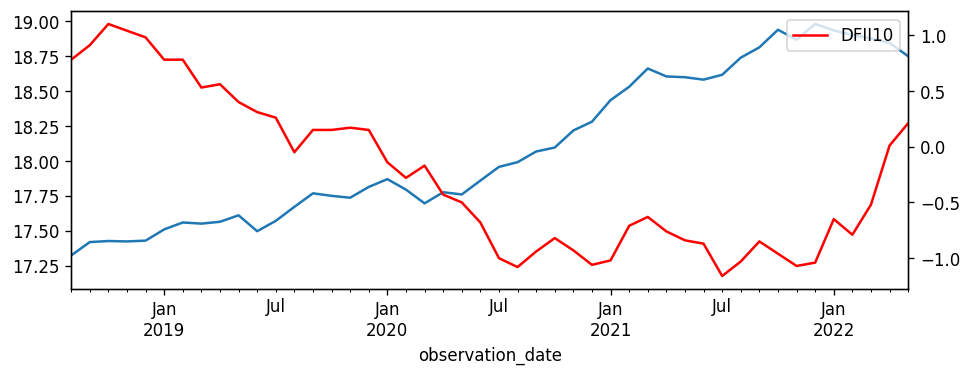

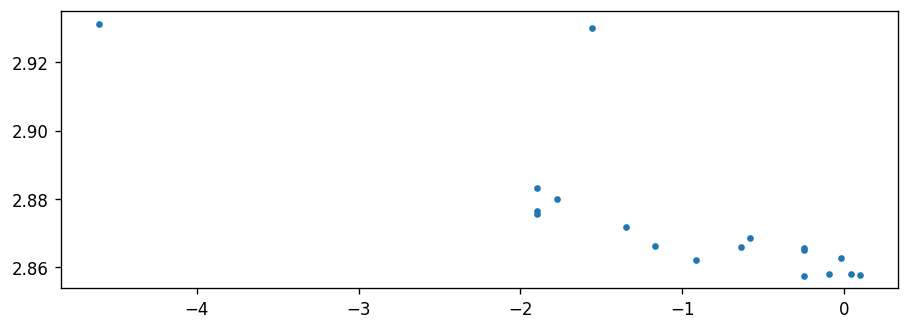

In [ ]:
import pandas_datareader as pdr
y = df2.iloc[:,0]['2018-07-01':]
y.plot()
print(y.iloc[-5:])

data = pdr.get_data_fred("DFII10", "2018-07-01", "2022-06-01").dropna()
ir = data.DFII10.asfreq("M",method='pad').asfreq('MS',method='bfill')

ax2 = plt.gca().twinx()
ir.plot(ax=ax2,color='r')
plt.legend()
print(ir.iloc[-5:])

plt.figure()
plt.plot(np.log(ir),np.log(y.iloc[-len(ir):]),'.')

Overall, there is a negative correlation between endogenous variables and exogenous variables. Figure 2 illustrates the scatter plot between the logged DFII10 and the endogenous variable, revealing a negative trend.

In [ ]:
#SARIMA(1,1,1)
ir = ir.reindex(df2.index).fillna(method='ffill').fillna(method='bfill')
modo = sm.tsa.SARIMAX(endog=df2[:'2021-07-01'], order=(1, 1, 1),exog=ir[:'2021-07-01'])
res  = modo.fit()
modt = sm.tsa.SARIMAX(endog=df2,order=(1, 1, 1), exog=ir)
rest = modt.filter(res.params)

print(rest.summary())

                               SARIMAX Results                                
Dep. Variable:                 logdb2   No. Observations:                   48
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  57.145
Date:                Fri, 15 Dec 2023   AIC                           -106.290
Time:                        03:49:14   BIC                            -98.889
Sample:                    07-01-2018   HQIC                          -103.505
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DFII10        -0.0633      0.066     -0.964      0.335      -0.192       0.065
ar.L1          0.7758      0.205      3.793      0.000       0.375       1.177
ma.L1         -0.4759      0.311     -1.532      0.1

In this particular case, a 1% increase in the total balance from one period ago leads to a 0.77% increase in the current balance. Moreover, a 1 percent increase in the ten-year treasury bill is associated with a 0.06% increase. Additionally, a 1 unit increase in the error term corresponds to a -0.98% increase in the current balance. The value of sigma square is 0.004, indicating a relatively low level of variability in the error term.

# Model performance





RMSE and MAE are chosen as our primary metrics for model accuracy comparison. RMSE measures the square root of the average squared differences between the predicted and actual values. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. For both metrics, lower values indicate better fit.

The RMSE is calculated by the formula:

$${RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$

The MAE is calculated by the formula:

$$ {MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$



By changing the order of the ARIMA and SARIMAX models, we conduct a horse race to compare their accuracy:


| Model | RMSE | MAE |       |  Model | RMSE | MAE |     
|-----|-----|  -----|       | -----| -----| -----|
| ARIMA(0,1,0) | 0.1470| 0.1240 |       |SARIMAX(2,1,1) |0.1318 |0.1068 |
| ARIMA(0,1,1)  |0.1476| 0.1247 |     |SARIMAX(1,1,2)|0.1431 |0.1108 |
| ARIMA(1,1,0)  |0.1550| 0.1330|  |SARIMAX(0,1,0)|0.2159 |0.1946 |
| ARIMA(0,1,2)  |0.1601| 0.1385|       |SARIMAX(0,1,1)|0.2262 |0.2046 |
| ARIMA(2,1,1)  | 0.1816 | 0.1613 |      |SARIMAX(0,1,2)|0.2375 |0.2155 |
 | ARIMA(2,1,0)  |0.1949| 0.1751|       |SARIMAX(1,1,0)|0.2404 |0.2186 |
| ARIMA(1,1,2)  |0.2020| 0.1841|      |SARIMAX(2,1,0)|0.2561 |0.2340|
 | ARIMA(1,1,1)  |0.2290| 0.2109|         |SARIMAX(2,1,2)|0.2681 |0.2465|
| ARIMA(2,1,2)  |0.2427| 0.2241 |     |SARIMAX(1,1,1)|0.2684 |0.2471 |


It is noticeable that some models with low complexity exhibit low accuracy as well.






Based on the comparison of RMSE, MAE, and their corresponding forecasting plots, we have chosen SARIMAX(2,1,1) as our final forecast model：

$$\Delta ln x_t = 1.21 \Delta ln x_{t-1} - 0.21 \Delta ln x_{t-2} -0.03 y_t + \varepsilon_t \\
\varepsilon_t = - 0.98 \Delta\varepsilon_{t-1} + n_t $$

where:

$\ln x_t $ is the log of observed time series at time t

$y_t $  is the exogenous variables at time t

$\varepsilon_t$ is the error term at time t

$n_t $ is the white noise error term at time t.

The SARIMA(2,1,1) model suggests better predictions for our dataset. In this model, a 1% rise in the previous period's loan balance increases the current balance by 1.21%, while a 1% rise from two periods ago decreases it by 0.21%. A 1% hike in the ten-year treasury bill rate lowers the current balance by 0.03%. Additionally, the error term's variance is 0.005, indicating low variability in predictions.

## Residual Plot


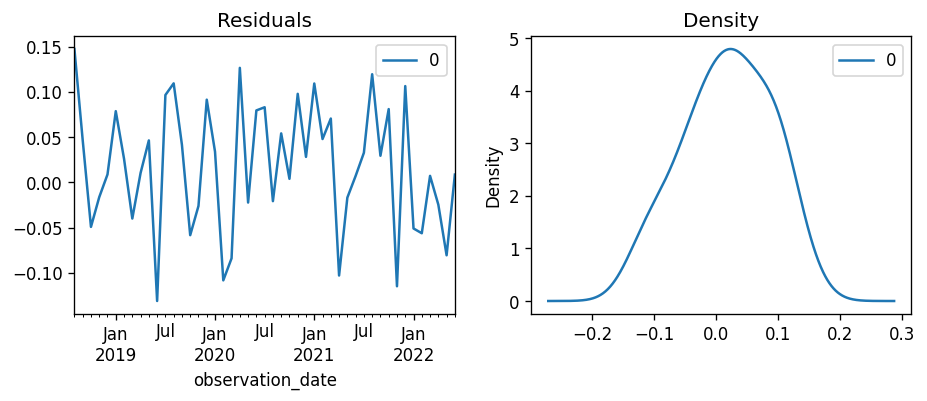

In [ ]:
# Plot residual errors of ARIMA(0,1,1)

model1 = sm.tsa.ARIMA(endog=df2, order=(2, 1, 1)) #The order for ARIMA's accuracy metrics calculation and forecsting plots
model_fit1 = model1.fit()

residuals = pd.DataFrame(model_fit1.resid).iloc[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


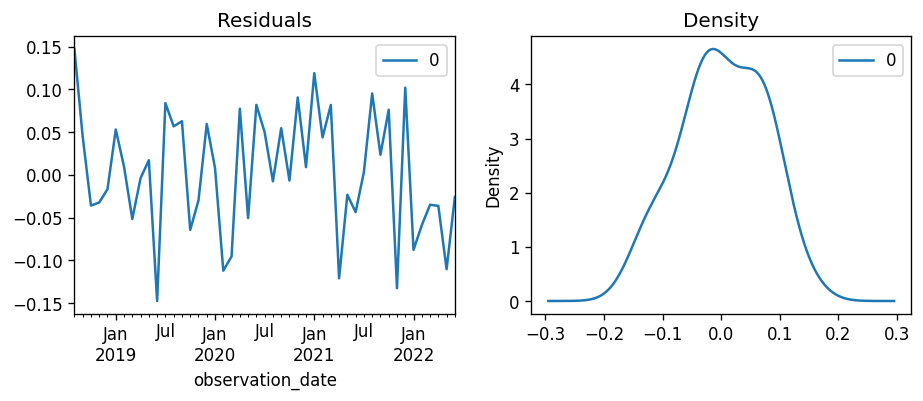

In [ ]:
# Plot residual errors of SARIMAX(2,1,1)

# Fit SARIMAX model
data1 = pdr.get_data_fred("DFII10", "2022-06-01", "2023-07-01").dropna()
ir1 = data1.DFII10.asfreq("M",method='pad').asfreq('MS',method='bfill')

modo1 = sm.tsa.SARIMAX(endog=df2[:'2021-07-01'], order=(2, 1, 1),exog=ir[:'2021-07-01'])
res1  = modo1.fit()
modt1 = sm.tsa.SARIMAX(endog=df2,order=(2, 1, 1), exog=ir) #The order for SARIMAX's accuracy metrics calculation and forecsting plots
rest1 = modt1.filter(res1.params)

residuals1 = pd.DataFrame(rest1.resid).iloc[1:]
fig, ax = plt.subplots(1,2)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residuals range from -0.2 to 0.3, without any noticeable trend or periodic pattern. This suggests the model may be appropriate. The majority of residuals cluster around zero, indicative of a well-fitted model. The random distribution of residuals indicates a good fit to the data.






## Model Accuracy



In [ ]:
#Fit the ARIMA model
test = df2.logdb2.iloc[36:]
forecast = model_fit1.get_forecast(steps=12)
fc = forecast.predicted_mean
conf = forecast.conf_int()

In [ ]:
# Accuracy metrics of ARIMA model
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': 0.008542690147321912,
 'me': -0.14736325186089339,
 'mae': 0.1612941651561961,
 'mpe': -0.007794399624136617,
 'rmse': 0.18161651269120804}

In [ ]:

#new ir range
pdpredict_rng = pd.date_range('2022-07-01', '2023-06-01', freq='MS')
data2 = pdr.get_data_fred("DFII10", "2022-07-01", "2023-06-01").dropna()
ir2 = data2.DFII10.asfreq("M",method='pad').asfreq('MS',method='bfill')
ir2 = ir2.reindex(pdpredict_rng).fillna(method='ffill').fillna(method='bfill')

# SARIMA()
ir_extended = pd.concat([ir, ir2])
pred = rest1.get_prediction(start='2022-7-01', end='2023-06-01', dynamic=True, exog=ir_extended.loc['2022-07-01':'2023-06-01'])
pred_loan = pred.conf_int()


forecast_accuracy(pred.predicted_mean, test.values)

{'mape': 0.005677213585169081,
 'me': 0.022307858297753096,
 'mae': 0.10681837238973912,
 'mpe': 0.0012118917243474465,
 'rmse': 0.13183334515980974}

In [ ]:

ir2_reset = ir2.reset_index().rename(columns={'index': 'date'})
first_column_list2 = ir2_reset.iloc[:,1]


print(first_column_list2.to_string(index=False))

0.67
0.67
1.68
1.58
1.34
1.58
1.28
1.49
1.16
1.26
1.46
1.46


After calculating the accuracy metrics, we discovered that some model with a better balance between model complexity and goodness of fit displays low accuracy on forecast. Model with the lowest AIC such as ARIMA(1,1,1), SARIMAX(1,1,1) displaying the lowest accuracy.

This might because a model with lower AIC/BIC may be simpler and provide a good explanation for the available data. However, it may not capture all the complexity of the data, resulting in reduced prediction accuracy. On the other hand, a more complex model may better capture the intricate details and improve prediction accuracy.

Therefore, to strike a balance between model accuracy and interpretability, it is important to consider models with relatively high accuracy, even if they have a high AIC.

# Forecasting


In [ ]:
pred.predicted_mean

2022-07-01    18.728879
2022-08-01    18.753779
2022-09-01    18.748207
2022-10-01    18.778435
2022-11-01    18.813185
2022-12-01    18.832591
2023-01-01    18.869211
2023-02-01    18.889512
2023-03-01    18.927025
2023-04-01    18.950772
2023-05-01    18.971293
2023-06-01    18.998168
Freq: MS, Name: predicted_mean, dtype: float64

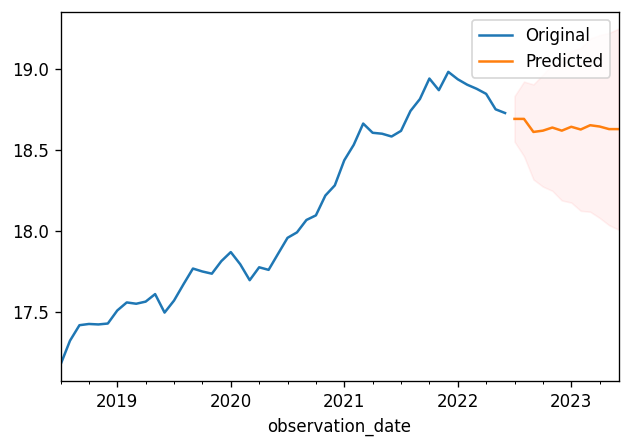

In [ ]:
#SARIMA(2,1,1) forecasting plot

fig, ax = plt.subplots(figsize=(6, 4))
df2.logdb2.plot(ax=ax, label='Original')
pred.predicted_mean.plot(ax=ax, label='Predicted')
ax.fill_between(pred_loan.index, pred_loan.iloc[:, 0], pred_loan.iloc[:, 1], color='r', alpha=0.05)
plt.legend()
plt.show()

Despite the flat forecast line, a subtle upward trend indicates a potential slow increase in predicted values. The data lacks clear seasonality or cyclicality, suggesting that the model may not have captured these patterns very well. Meanwhile, the model appears to prioritize smooth long-term trends over short-term fluctuations.

In [ ]:
# ARIMA(0,1,1) forecasting plot

# fig, ax = plt.subplots(figsize=(6, 4))
# df2.logdb2.plot(ax=ax, label='Original')
# fc.plot(ax=ax, label='Predicted')
# ax.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='r', alpha=0.05)
# plt.legend()
# plt.show()


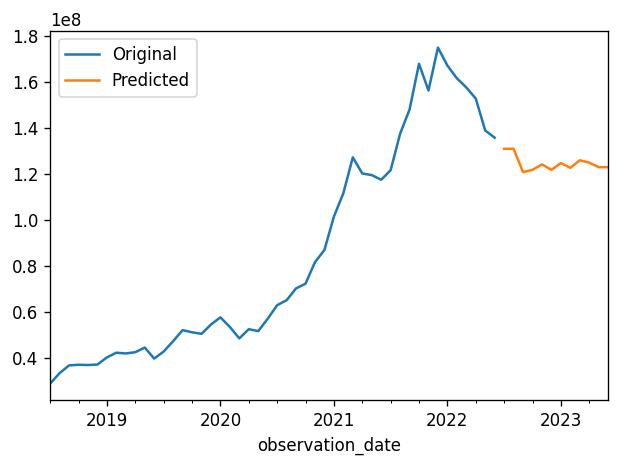

In [ ]:
# The total balance of loan portfolio
forecast = np.exp(pred.predicted_mean)
ori = np.exp(df2.logdb2)
fig, ax = plt.subplots(figsize=(6, 4))
ori.plot(ax=ax, label='Original')
forecast.plot(ax=ax, label='Predicted')
plt.legend()
plt.show()

If we convert the logarithmic data back to its original scale, we observe a minor declining trend in the forecasted values. The projected total balance is expected to range from 120 million to 130 million over the next 12 months.